# Final Project: Predicting Spending on Technology

In [428]:
# importing relevant packages and the data 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
%matplotlib inline

data_all = pd.read_csv('C:/Users/lwhitbeck/Documents/Training/GA Data Science/responses.csv')
X = pd.read_csv('C:/Users/lwhitbeck/Documents/Training/GA Data Science/responses.csv')
y = X.pop('Spending on gadgets')

In [429]:
# looking at dimensions
data_all.shape

(1010, 150)

### The dataset has 150 variables:
  - 149 features 
  - 1 target variable which I am using 'Spending on gadgets' as a proxy for spending on technology
  - Also, I am interested in how music specifically predicts spending on technology
  - The variabes can be broken up into various categories:
  - Music Preferences (19 items)
      - Movie preferences (12 items)
      - Hobbies & interests (32 items)
      - Phobias (10 items)
      - Health habits (3 items)
      - Personality traits, views on life, & opinions (57 items)
      - Spending habits (7 items)
      - Demographics (10 items)


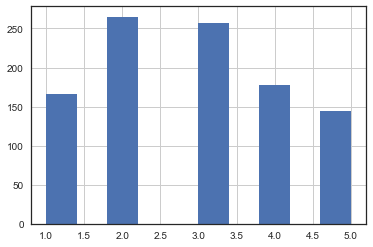

In [430]:
# looking at potential target variable
y.hist();

In [431]:
# looking at the actual counts 
y.value_counts()

2    265
3    257
4    178
1    166
5    144
Name: Spending on gadgets, dtype: int64

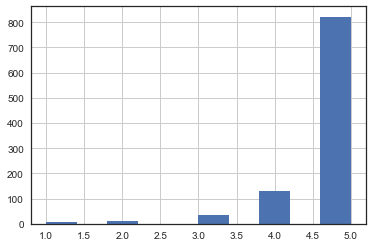

In [432]:
# looking at independent variable of interest
X['Music'].hist();

# Correlation Analysis
    - Ran a correlation matrix on all the data but it wasn't readable so creating the categories to take a closer look
    - Once I have the categories broken down I am going to take a look at the spending habits correlations and then some of  the other categories
    -Favorite findings:
        - Saving and spending money are negatively correlated (as expected!) 
            - the strongest negative correlation within spending habits is saving and entertainment spending
        - Interest in theatre and interest in reading have a strong positive correlation 
        - Phobias are all positively related!

In [433]:
# Seperating Categories
Music = data_all.iloc[:,0:19]
Movies =  data_all.iloc[:,19:31]
HobbiesAndInterests = data_all.iloc[:,31:62]
Phobias = data_all.iloc[:,63:73]
HealthHabits = data_all.iloc[:,73:76]
Personality = data_all.iloc[:,76:133]
SpendingHabits = data_all.iloc[:,133:140]
Demographics =  data_all.iloc[:,140:]

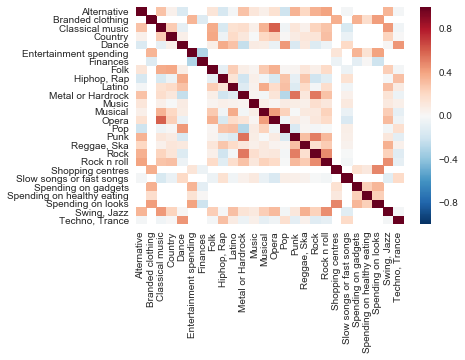

In [434]:
#looking at the relationship between Spending and Music
frames = [SpendingHabits, Music]
both_frames = pd.concat(frames)

corrmat = both_frames.corr()
sns.heatmap(corrmat);

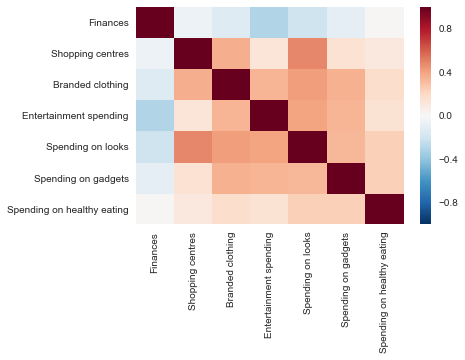

In [435]:
# Spending Correlation Matrix 
corrmat = SpendingHabits.corr()
sns.heatmap(corrmat);

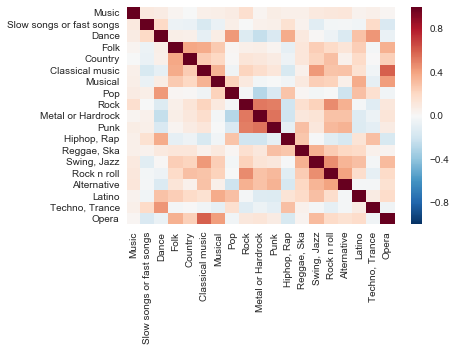

In [436]:
# Music Correlation Matrix 
corrmat = Music.corr()
sns.heatmap(corrmat);

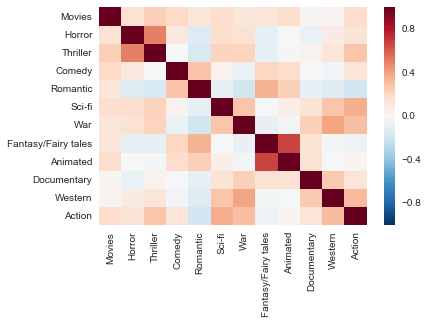

In [437]:
# Movies Correlation Matrix 
corrmat = Movies.corr()
sns.heatmap(corrmat);

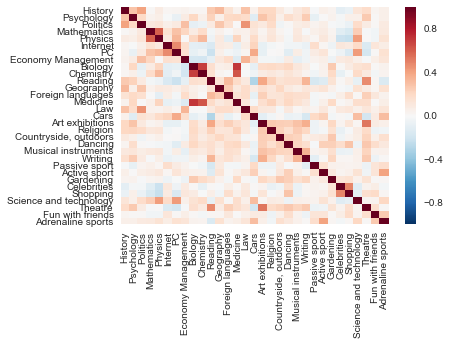

In [438]:
# Hobbies and Interests Correlation Matrix 
corrmat = HobbiesAndInterests.corr()
sns.heatmap(corrmat);

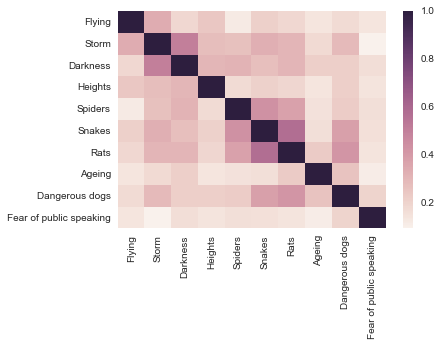

In [439]:
# Phobias Correlation Matrix 
corrmat = Phobias.corr()
sns.heatmap(corrmat);

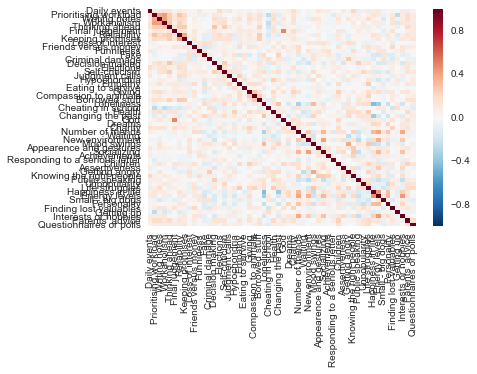

In [440]:
# Peronality Correlation Matrix 
corrmat = Personality.corr()
sns.heatmap(corrmat);

### Summary Stats:

In [441]:
# Summarizing Spending habits
SpendingHabits.describe().round(2)

,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating
count,1007.00,1008.00,1008.00,1007.00,1007.00,1010.00,1008.00
mean,3.02,3.23,3.05,3.20,3.11,2.87,3.56
std,1.14,1.32,1.31,1.19,1.21,1.28,1.09
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,2.00,2.00,2.00,3.00
50%,3.00,3.00,3.00,3.00,3.00,3.00,4.00
75%,4.00,4.00,4.00,4.00,4.00,4.00,4.00
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00


In [442]:
# fixing column visibiltiy in jupyter window to then look at the summary statistics for all
def printall(X, max_rows = 10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows = max_rows)))

# summary stats
printall(X.describe())    

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1007.000000,1008.000000,1006.000000,1005.000000,1005.000000,1003.000000,1008.000000,1007.000000,1004.000000,1007.000000,1002.000000,1006.000000,1003.000000,1004.000000,1003.000000,1003.000000,1002.000000,1003.000000,1009.000000,1004.000000,1008.000000,1009.000000,1007.000000,1007.000000,1008.000000,1008.000000,1007.000000,1007.000000,1002.000000,1006.000000,1008.000000,1008.000000,1005.000000,1009.000000,1007.000000,1007.000000,1006.000000,1004.000000,1005.000000,1004.000000,1000.000000,1004.000000,1001.000000,1005.000000,1005.000000,1009.000000,1006.000000,1004.000000,1007.000000,1003.000000,1007.000000,1009.000000,1004.000000,995.000000,1006.000000,1003.000000,1008.000000,1008.000000,1004.000000,1002.000000,1006.000000,1007.000000,1006.00000,1007.000000,1009.000000,1008.000000,1007.000000,1005.000000,1010.000000,1007.000000,1009.000000,1009.000000,1009.000000,1007.000000,1003.000000,1005.000000,1007.000000,1005.000000,1007.000000,1003.000000,1006.000000,1009.000000,1006.000000,1004.000000,1006.000000,1009.000000,1003.000000,1006.000000,1007.000000,1005.000000,1006.000000,1006.000000,1005.000000,1010.000000,1004.000000,1003.000000,1008.000000,1009.000000,1006.000000,1009.000000,1008.000000,1008.000000,1010.000000,1007.000000,1010.000000,1007.000000,1008.000000,1006.000000,1007.000000,1005.000000,1008.000000,1004.000000,1006.000000,1008.000000,1006.000000,1008.000000,1008.000000,1007.000000,1007.000000,1006.000000,1005.000000,1006.000000,1006.000000,1006.000000,1005.000000,1007.000000,1008.000000,1006.000000,1007.000000,1008.000000,1008.000000,1007.000000,1007.000000,1008.00000,1003.000000,990.000000,990.000000,1004.000000
mean,4.731877,3.328373,3.113320,2.288557,2.123383,2.956132,2.761905,3.471698,3.761952,2.361470,2.456088,2.910537,2.769691,2.759960,3.141575,2.828514,2.842315,2.338983,2.139742,4.613546,2.793651,3.383548,4.494538,3.489573,3.113095,3.155754,3.749752,3.788481,3.643713,2.126243,3.536706,3.207341,3.138308,2.595639,2.334657,2.064548,4.175944,3.136454,2.643781,2.665339,2.165000,3.159363,3.082917,3.778109,2.516418,2.256690,2.686879,2.589641,2.273088,3.686939,2.461768,2.324083,1.901394,3.387940,3.291252,1.907278,2.362103,3.276786,3.234064,3.024950,4.557654,2.948361,3.33499,2.061569,1.973241,2.250992,2.615690,2.82

### Missing data check:

In [443]:
# Checking missing data for any row
X.dropna(how='any').shape

(674, 149)

In [444]:
# How much missing data is there?
X.isnull().sum().sort_values(ascending = False)

Weight                            20
Height                            20
Passive sport                     15
Chemistry                         10
Geography                          9
Punk                               8
Latino                             8
Smoking                            8
Theatre                            8
Documentary                        8
Classical music                    7
Age                                7
Gardening                          7
Compassion to animals              7
Daily events                       7
Rock n roll                        7
Alternative                        7
Countryside, outdoors              7
Techno, Trance                     7
Final judgement                    7
Criminal damage                    7
Reggae, Ska                        7
Friends versus money               6
Reading                            6
Responding to a serious letter     6
Science and technology             6
Art exhibitions                    6
B

In [445]:
X.isnull().sum().median()

4.0

### Missing Values Impute:
 - The median of missing values is 4 observations
 - Going to impute the missing values with the median since theres only a very small percentage of values with missing data

In [446]:
# going to get a list of the numeric variables and replace it with the median since its a small amount
numeric_col = []

for column in X.columns:

    if X[column].dtype == np.float64 or X[column].dtype == np.int64:
        numeric_col.append(column) 
        X[column].fillna(X[column].median(), inplace = True)

In [447]:
#double checking the imputation worked
printall(X.describe()) 

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000
mean,4.732673,3.327723,3.112871,2.287129,2.122772,2.956436,2.762376,3.473267,3.763366,2.360396,2.452475,2.910891,2.771287,2.761386,3.140594,2.829703,2.843564,2.336634,2.139604,4.615842,2.794059,3.384158,4.496040,3.491089,3.112871,3.155446,3.750495,3.789109,3.646535,2.125743,3.537624,3.206931,3.137624,2.59505,2.333663,2.064356,4.175248,3.135644,2.640594,2.661386,2.163366,3.158416,3.082178,3.779208,2.513861,2.256436,2.688119,2.586139,2.272277,3.689109,2.460396,2.323762,1.89604,3.382178,3.290099,1.900990,2.361386,3.276238,3.232673,3.024752,4.559406,2.948515,3.337624,2.061386,1.973267,2.250495,2.613861,2.826

### Modeling data prep:
    - Going to only include the numerical variables to start
    - Having trouble with multiclass prediction so I am going to use high spender low spender approach
    - I am cutting the variables between 2/3 since there is a clear split between those values in the histogram below

In [448]:
# getting the numerical variables 
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on healthy eating,Age,Height,Weight,Number of siblings
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,3.0,4.0,5.0,3.0,3.0,3.0,20.0,163.0,48.0,1.0
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,3.0,4.0,1.0,4.0,2.0,2.0,19.0,163.0,58.0,2.0
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,2.0,4.0,1.0,4.0,3.0,2.0,20.0,176.0,67.0,2.0
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,2.0,4.0,3.0,3.0,4.0,1.0,22.0,172.0,59.0,1.0
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,4.0,3.0,4.0,3.0,3.0,4.0,20.0,170.0,59.0,1.0


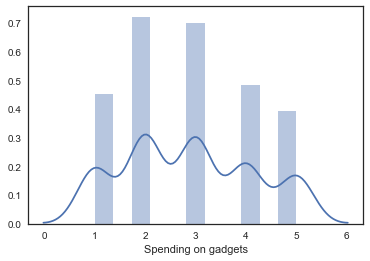

In [449]:
# looking at where to cut the data
sns.distplot(y)

In [450]:
y.value_counts()

2    265
3    257
4    178
1    166
5    144
Name: Spending on gadgets, dtype: int64

In [451]:
# Since swtiching to the AUC curve applies only to binary variables 
y = [1 if x >= 3 else 0 for x in y]

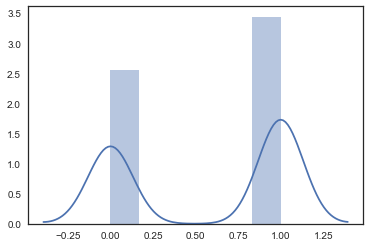

In [452]:
# looking at where to cut the data
sns.distplot(y)

### Running first "baseline" model:

In [465]:
from sklearn.cross_validation import cross_val_score

model = RandomForestClassifier(random_state = 5)
model.fit(X[numeric_variables], y)

print cross_val_score(model, X[numeric_variables], y, cv = 10, scoring = 'accuracy').mean()

0.631733061541


### First model results:
    - Not that great
### Going to add in the categorical data:

In [454]:
# looking at the categorical variables 
def describe_categorical(X):
    from IPython.display import display, HTML
    display (HTML(X[X.columns[X.dtypes == 'object']].describe().to_html()))

In [455]:
describe_categorical(X)

,Smoking,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
count,1002,1005,1008,1008,1010,1004,1007,1009,1008,1006,1006
unique,4,3,3,4,4,2,2,6,2,2,2
top,tried smoking,social drinker,i am always on time,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats
freq,430,659,399,549,744,593,906,621,754,707,595


In [456]:
# Dummy out the categorical variables
categorical_variables = ['Smoking', 'Alcohol', 'Punctuality','Lying','Internet usage','Gender','Left - right handed','Education', 'Only child', 'Village - town', 'House - block of flats']

for variable in categorical_variables:
    X[variable].fillna("Missing", inplace=True)
    dummies = pd.get_dummies(X[variable], prefix = variable)
    X  = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1,inplace=True)

In [457]:
#checking new dimensions 
X.shape

(1010, 182)

In [459]:
model = RandomForestClassifier(n_estimators = 1000, 
                                  oob_score = True, 
                                  n_jobs = -1, 
                                  random_state = 42, 
                                  max_features = "sqrt",
                                  min_samples_leaf = 4)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [466]:
model = RandomForestClassifier(random_state = 5)
model.fit(X, y)

print cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()

0.628645117453


In [467]:
from sklearn.cross_validation import cross_val_score
print cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()

0.628645117453


### Model with Categorical and Numeric features:
    -Slightly better but not by much.  Going to optimize on which features and the number of features.

### Refining the model by running optimal parameter tests:

#### n_jobs

In [470]:
%%timeit
model = RandomForestClassifier(100, oob_score = True, n_jobs = 1, random_state = 5)
model.fit(X, y)

print cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()

0.683154938533
0.683154938533
0.683154938533
0.683154938533
1 loop, best of 3: 1.86 s per loop


In [471]:
%%timeit
model = RandomForestClassifier(100, oob_score = True, n_jobs = -1, random_state = 5)
model.fit(X, y)

print cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()

0.683154938533
0.683154938533
0.683154938533
0.683154938533
1 loop, best of 3: 5.62 s per loop


#### n_estimators

30 trees
cross_val_score:  0.671269268103

50 trees
cross_val_score:  0.68221995729

100 trees
cross_val_score:  0.691091050281

200 trees
cross_val_score:  0.69110036886

500 trees
cross_val_score:  0.692110463988

1000 trees
cross_val_score:  0.689149873811

30 trees
cross_val_score:  0.671269268103

50 trees
cross_val_score:  0.68221995729

100 trees
cross_val_score:  0.691091050281

200 trees
cross_val_score:  0.69110036886

500 trees
cross_val_score:  0.692110463988

1000 trees
cross_val_score:  0.689149873811

30 trees
cross_val_score:  0.671269268103

50 trees
cross_val_score:  0.68221995729

100 trees
cross_val_score:  0.691091050281

200 trees
cross_val_score:  0.69110036886

500 trees
cross_val_score:  0.692110463988

1000 trees
cross_val_score:  0.689149873811

30 trees
cross_val_score:  0.671269268103

50 trees
cross_val_score:  0.68221995729

100 trees
cross_val_score:  0.691091050281

200 trees
cross_val_score:  0.69110036886

500 trees
cross_val_score:  0.692110463988

1

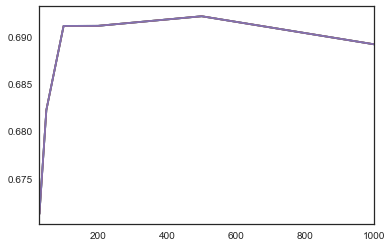

In [474]:
%%timeit 
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000]

for trees in n_estimator_options:
    model = RandomForestClassifier(trees, n_jobs = 1, random_state = 5)
    model.fit(X[numeric_variables], y)
    print trees, "trees"
    cross_val_scoring = cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()
    print "cross_val_score: ", cross_val_scoring
    results.append(cross_val_scoring)
    print ""
    
pd.Series(results, n_estimator_options).plot()    


#### max_features

auto option
cross_val_score:  0.689149873811

None option
cross_val_score:  0.687091050281

sqrt option
cross_val_score:  0.689149873811

log2 option
cross_val_score:  0.681189671908

0.9 option
cross_val_score:  0.689090856144

0.2 option
cross_val_score:  0.699992040381



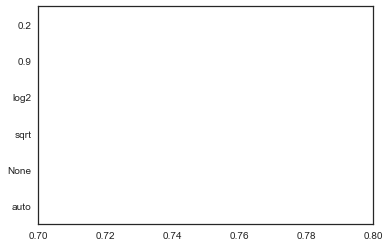

In [475]:
#learned rule of thumb for features in classifier model is the sqrt of the number of features. As demonstrated below, it raises our score so going to use that in the final model.
results = []
max_features_options = ['auto', None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestClassifier(n_estimators = 1000, n_jobs = 1, random_state = 5, max_features = max_features)
    model.fit(X[numeric_variables], y)
    print max_features, "option"
    cross_val_scoring = cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()
    print "cross_val_score: ", cross_val_scoring
    results.append(cross_val_scoring)
    print ""
    
pd.Series(results, max_features_options).plot(kind = "barh", xlim=(.7, .8));    


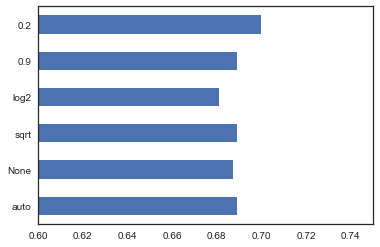

In [478]:
pd.Series(results, max_features_options).plot(kind = "barh", xlim=(.6, .75));    


#### min_sample_leaves

1 min samples
cross_val_score:  0.689149873811

2 min samples
cross_val_score:  0.693110075713

3 min samples
cross_val_score:  0.689139778684

4 min samples
cross_val_score:  0.691119976704

5 min samples
cross_val_score:  0.69110036886

6 min samples
cross_val_score:  0.693119782566

7 min samples
cross_val_score:  0.68716909338

8 min samples
cross_val_score:  0.693109881576

9 min samples
cross_val_score:  0.684179188507

10 min samples
cross_val_score:  0.689149485537



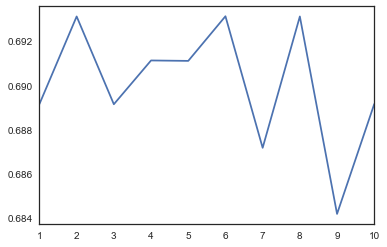

In [481]:
# peak is at 4 here so going to use that

results = []
min_samples_leaf_options = [1,2,3,4,5,6,7,8,9,10]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators = 1000,
                                   n_jobs = 1, 
                                   random_state = 5, 
                                   max_features = "sqrt", 
                                   min_samples_leaf = min_samples )
    model.fit(X[numeric_variables], y)
    print min_samples, "min samples"
    cross_val_scoring = cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()
    print "cross_val_score: ", cross_val_scoring
    results.append(cross_val_scoring)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();   


# Feature Importance:

In [337]:
Xn = X[numeric_variables]
y = y

In [483]:
model = RandomForestClassifier(n_estimators = 500, 
                                  n_jobs = -1, 
                                  random_state = 5, 
                                  max_features = 0.2,
                                  min_samples_leaf = 6)
model.fit(Xn, y)
print cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()

0.7019722384


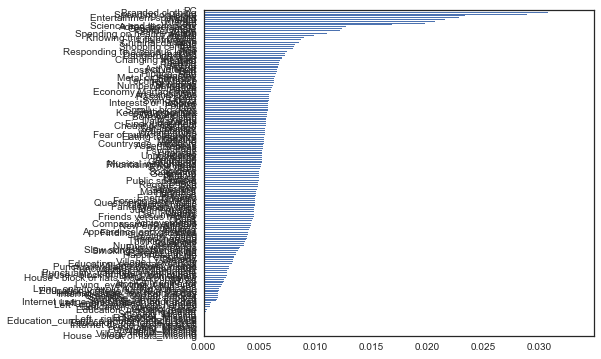

In [313]:
# graphing the above since its difficult to interpret
feature_importances = pd.Series(model.feature_importances_, index = Xn.columns)
feature_importances.sort_values(inplace = True)
feature_importances.plot(kind='barh', figsize=(7,6));

In [315]:
# collapsing the dummy variables to make the above chart more readable
model = RandomForestClassifier(n_estimators = 1000, 
                                  oob_score = True, 
                                  n_jobs = -1, 
                                  random_state = 42, 
                                  max_features = "sqrt",
                                  min_samples_leaf = 4)
model.fit(Xn, y)

def graph_feature_importances(model, feature_names, autoscale = True, headroom = 0.05, width = 10, summarized_columns = None):
        if autoscale:
            x_scale = model.feature_importances_.max()+headroom
        else:
            x_scale = 1
        
        feature_dict = dict(zip(feature_names, model.feature_importances_))
        
        if summarized_columns:
            for col_name in summarized_columns:
                sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i)
                
                keys_to_remove = [i for i in feature_dict.keys() if col_name in i] 
                for i in keys_to_remove:
                    feature_dict.pop(i)
                    
                feature_dict[col_name] = sum_value
                
        results = pd.Series(feature_dict.values(), index = feature_dict.keys())            
        results.sort(axis = 1)
        results.plot(kind = "barh", figsize=(width, len(results)/4), xlim=(0, x_scale))


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


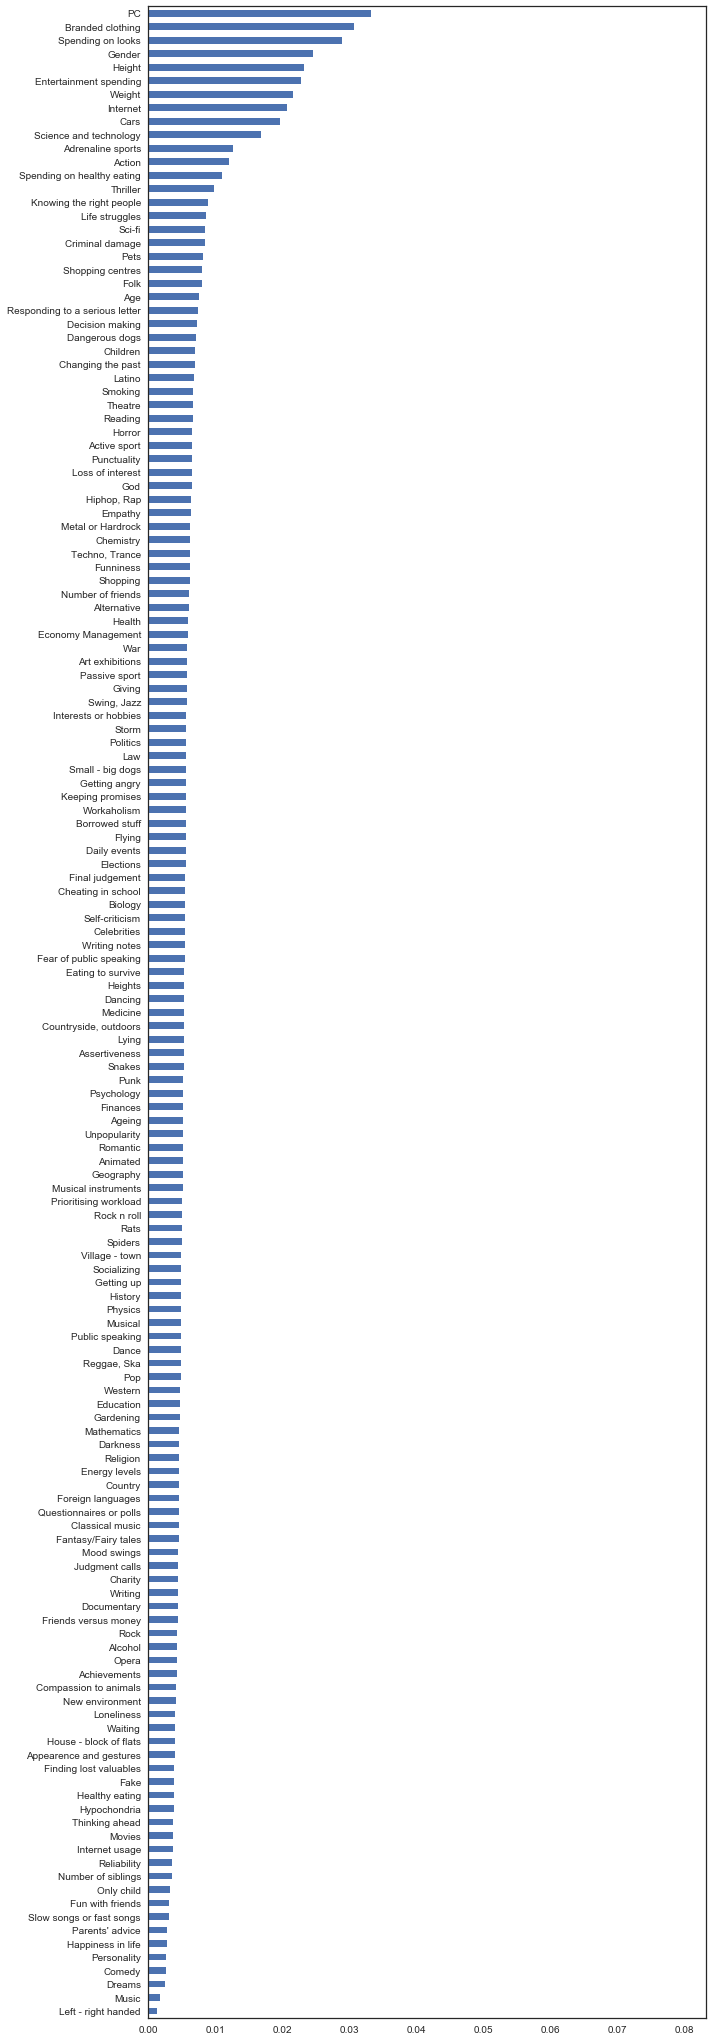

In [325]:
graph_feature_importances(model, Xn.columns, summarized_columns = categorical_variables)

In [339]:
top_features = pd.DataFrame(data_all, columns =['Spending on gadgets', 'PC', 'Branded clothing', 'Spending on looks', 'Gender', 'Height',
                                               'Entertainment spending', 'Weight', 'Internet', 'Cars', 'Science and technology',
                                               'Adrenaline sports', 'Action', 'Spending on healthy eating', 'Thriller', 'Knowing the right people'])



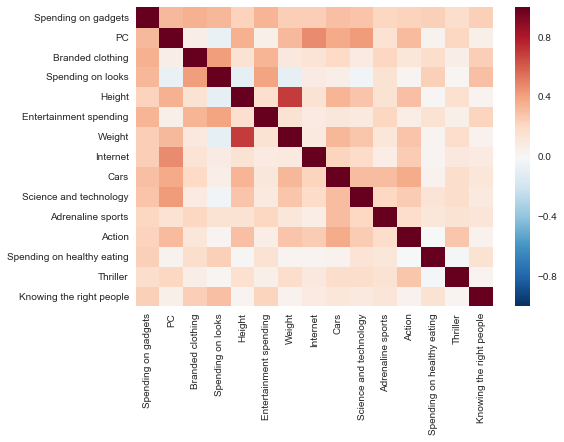

In [320]:
corrmat = top_features.corr()
sns.heatmap(corrmat);

### Cross validating the Different Models
    - cross validating the models to see which has the most accuracy
    - Testing KNN, Random Forest, and Logit

In [484]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
#testing KNN
knn = KNeighborsClassifier(n_neighbors=20)
print cross_val_score(knn, Xn, y, cv = 10, scoring = 'accuracy').mean()

0.6357239371


In [ ]:
#testing random forest classifier
RFC = RandomForestClassifier(n_estimators = 1000, 
                                  oob_score = True, 
                                  n_jobs = -1, 
                                  random_state = 42, 
                                  max_features = "sqrt",
                                  min_samples_leaf = 4)

print cross_val_score(RFC, Xn, y, cv = 10, scoring = 'accuracy').mean()

In [ ]:
#testing logit
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print cross_val_score(logreg, Xn, y, cv = 10, scoring = 'accuracy').mean()

In [ ]:
print cross_val_score(knn, Xn, y, cv = 10, scoring = 'accuracy').mean()
print cross_val_score(RFC, Xn, y, cv = 10, scoring = 'accuracy').mean()
print cross_val_score(logreg, Xn, y, cv = 10, scoring = 'accuracy').mean()

# Conclusion
    - the random forest worked best in terms of accuracy even with such a small data set
    - Logit was a close second
    - The model significantly decreases in accuracy (almost half) when I switch to a multiclass output
    - Music preferences have nothing to do with spending on techology
 

# The End !!